## Кластеризация основных типов масок

In [12]:
import pandas as pd
import os
import image_similarity as imgsim
import numpy as np

import re
import pathlib

In [8]:
real_mask_data_dir = os.path.join(os.path.dirname(os.getcwd()), "train_dataset/cv_open_dataset/open_msk")
synt_mask_data_dir = os.path.join(os.path.dirname(os.getcwd()), "train_dataset/cv_synt_dataset/synt_msk")
print(real_mask_data_dir)


/home/lazymanul/progs/camera_hack/train_dataset/cv_open_dataset/open_msk


In [13]:
def collect_files(data_dir, extension_regex):
    dir_files = pathlib.Path(data_dir).rglob("*")
    return [str(fname) for fname in dir_files if extension_regex.match(str(fname))]

In [14]:
jpg_extension = re.compile('.*jpg$', flags= re.IGNORECASE)
png_extension = re.compile('.*png$', flags= re.IGNORECASE)


In [15]:
# create images dataframe 
# columns: image_fname, image_id, tag = (syn/real)

def build_image_df(data_dir, extenstion_regex, tag):
    images = collect_files(data_dir, extenstion_regex)

    image_df = pd.DataFrame(images, columns=['image_fname'])
    image_df['image_id'] = image_df['image_fname'].apply(lambda x: x.split('/')[-1].split('.')[0])
    image_df['tag'] = tag
    
    return image_df


In [25]:
image_df = pd.concat(
    [ build_image_df(real_mask_data_dir, png_extension, 0), 
      build_image_df(real_mask_data_dir, png_extension, 1) ],
      ignore_index=True, sort=False)

In [26]:
# build embeddings for images

ImgSim = imgsim.Img2Vec('resnet18', weights='DEFAULT')

embeddings = []

for image_fname in image_df['image_fname']:
    embedding = ImgSim.embed_image(image_fname).cpu().detach().numpy()
    embeddings.append(embedding.reshape((-1)))

In [39]:
from sklearn.cluster import KMeans

data = np.array(embeddings)
kmeans_labels = KMeans(n_clusters=4).fit_predict(data)

In [ ]:
import umap

clusterable_embedding = umap.UMAP(    
    min_dist=0.1,
).fit_transform(data)

## Проверка качества сгенерированных масок 

(распределения сгенерированных и реальных данных должны быть представлены среди кластеров в ~равных пропорциях)

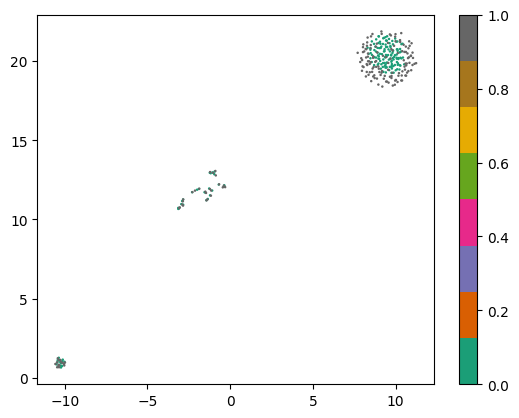

In [54]:
import matplotlib.pyplot as plt

plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1],
            c=image_df['tag'], s=0.6, cmap='Dark2')
plt.colorbar()
plt.show()

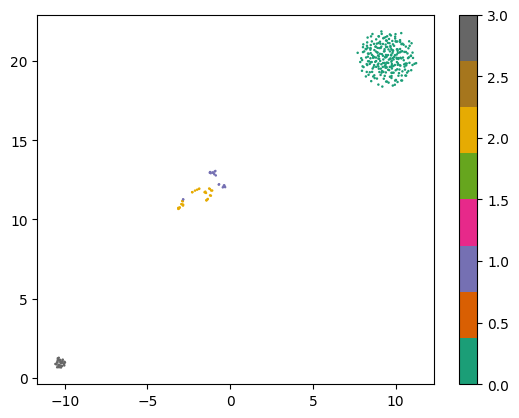

In [55]:
plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1],
            c=kmeans_labels, s=0.6, cmap='Dark2')
plt.colorbar()
plt.show()

In [41]:
image_df['color_cluster'] = kmeans_labels

In [42]:
image_df[['image_id', 'color_cluster']].groupby(by=['color_cluster']).count()

,image_id
color_cluster,
0,256
1,20
2,32
3,32


In [43]:
from PIL import Image
import random 
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

def plot_random_instanses(df, cluster_id, grid_size=2, figsize=(8., 8.)):
    image_cluster = df[df['color_cluster'] == cluster_id].reset_index(drop=True)
    cluster_size = len(image_cluster)

    images = []
    for i in range(grid_size * grid_size):
        index = random.randint(0, cluster_size)
        fname = image_cluster['image_fname'].iloc[index]        
        image = Image.open(fname)
        
        images.append(np.array(image))
    
    fig = plt.figure(figsize=figsize)
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(grid_size, grid_size), 
                 axes_pad=0.1,  # pad between Axes in inch.
                 )

    for ax, im in zip(grid, images):
        ax.imshow(im)
    plt.show()

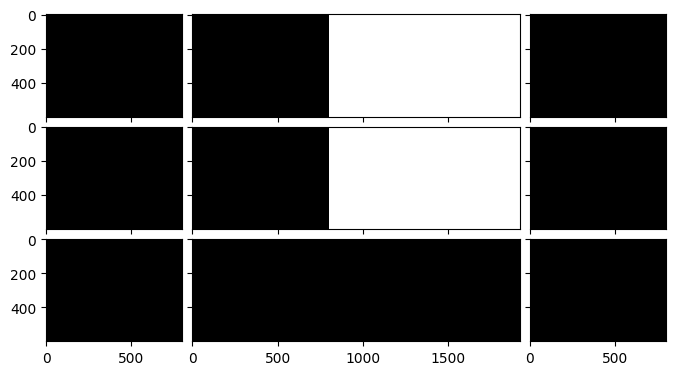

In [44]:
plot_random_instanses(image_df, 0, grid_size=3)

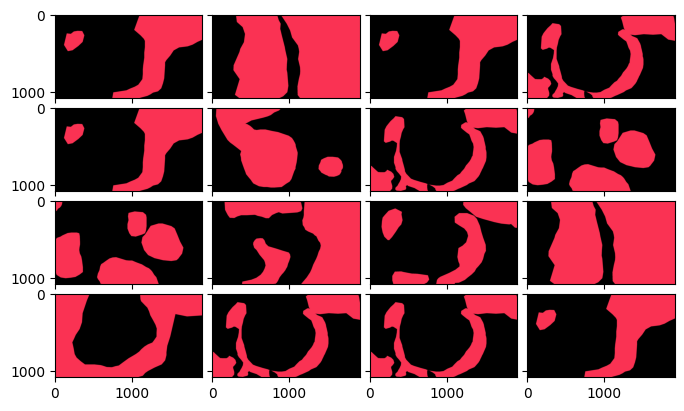

In [49]:
plot_random_instanses(image_df, 1, grid_size=4)

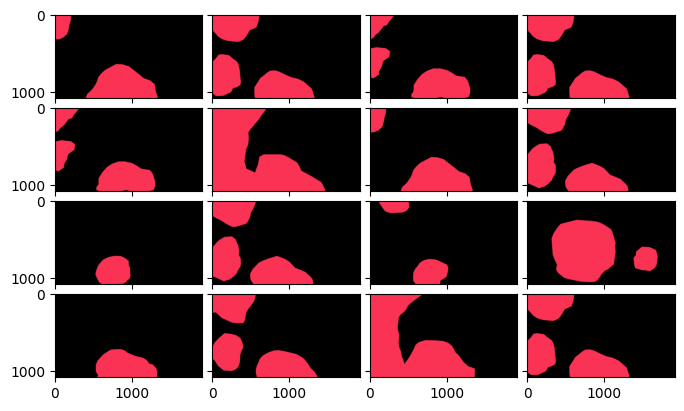

In [52]:
plot_random_instanses(image_df, 2, grid_size=4)

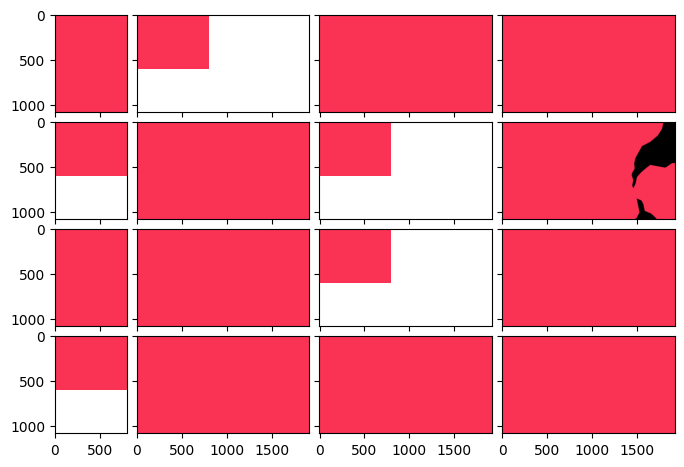

In [53]:
plot_random_instanses(image_df, 3, grid_size=4)